In [ ]:
!pip install pandas numpy matplotlib scikit-learn tensorflow keras pytorch

In [10]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from statsmodels.tsa.seasonal import STL
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv')
data.head()

In [13]:
plt.rcParams["figure.figsize"] = (11,4)


URL = "https://raw.githubusercontent.com/numenta/NAB/master/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv"
df = pd.read_csv(URL)
df.columns = ["timestamp","value"]

df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)


In [15]:
display(df.head(), df.describe())
print("Nulls:", df.isna().sum().to_dict())

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


,timestamp,value
count,4032,4032.000000
mean,2014-02-21 14:27:30,0.126303
min,2014-02-14 14:30:00,0.066000
25%,2014-02-18 02:28:45,0.132000
50%,2014-02-21 14:27:30,0.134000
75%,2014-02-25 02:26:15,0.134000
max,2014-02-28 14:25:00,2.344000
std,NaN,0.094813


Nulls: {'timestamp': 0, 'value': 0}


In [ ]:
fig, ax = plt.subplots()
ax.plot(df["timestamp"], df["value"])
ax.set_title("EC2 CPU Utilization"); ax.set_xlabel("time"); ax.set_ylabel("cpu")
plt.show()

In [17]:
df["date"] = df["timestamp"].dt.date
daily = df.groupby("date")["value"].agg(["mean","max","min","std"]).reset_index()
display(daily.head())

,date,mean,max,min,std
0,2014-02-14,0.125912,0.202,0.066,0.029359
1,2014-02-15,0.123076,1.466,0.066,0.084817
2,2014-02-16,0.122042,1.534,0.066,0.089016
3,2014-02-17,0.125826,1.398,0.066,0.082018
4,2014-02-18,0.128104,1.534,0.066,0.089032


In [ ]:
df = df.set_index("timestamp")
# Choose a window (~1 hour if ~ per-5min sampling). Adjust if needed.
win = 12


In [20]:
df["roll_mean"] = df["value"].rolling(win, min_periods=win//2).mean()
df["roll_std"]  = df["value"].rolling(win, min_periods=win//2).std()
df["zscore"]    = (df["value"] - df["roll_mean"]) / (df["roll_std"] + 1e-6)

In [21]:
stl = STL(df["value"].interpolate(limit_direction="both"), period=288, robust=True)  # ~ 24h if 5-min intervals
res = stl.fit()
df["trend"] = res.trend
df["seasonal"] = res.seasonal
df["resid"] = res.resid

In [22]:
# Lag features
for lag in [1,2,3,6,12]:
    df[f"lag_{lag}"] = df["value"].shift(lag)

In [23]:
# Drop early NaNs from rolling/lag
df_fe = df.dropna().copy()

In [24]:
feature_cols = ["value","roll_mean","roll_std","zscore","trend","seasonal","resid"] + \
               [c for c in df_fe.columns if c.startswith("lag_")]
X = df_fe[feature_cols].values

In [25]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [26]:
iso = IsolationForest(
    n_estimators=300,
    max_samples="auto",
    contamination=0.01,   # adjust; or tune via validation heuristic
    random_state=42
)
iso.fit(Xs)

IsolationForest(contamination=0.01, n_estimators=300, random_state=42)

In [27]:
scores_iso = -iso.score_samples(Xs)  # higher = more anomalous
df_fe["anomaly_iso_score"] = scores_iso

In [28]:
# Heuristic threshold: top k% as anomalies
k = int(0.01 * len(df_fe))
thr_iso = np.sort(scores_iso)[-k] if k>0 else np.percentile(scores_iso, 99)
df_fe["anomaly_iso"] = (df_fe["anomaly_iso_score"] >= thr_iso).astype(int)

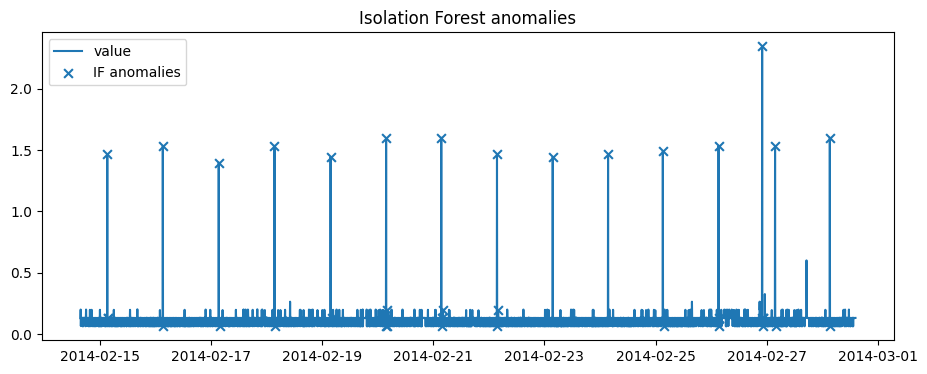

In [29]:
# Visualize
fig, ax = plt.subplots()
ax.plot(df_fe.index, df_fe["value"], label="value")
ax.scatter(df_fe.index[df_fe["anomaly_iso"]==1], df_fe.loc[df_fe["anomaly_iso"]==1,"value"],
           marker="x", s=40, label="IF anomalies")
ax.legend(); ax.set_title("Isolation Forest anomalies")
plt.show()

In [30]:
SEQ_LEN = 24  # adjust
seq_data = []
for i in range(len(Xs)-SEQ_LEN):
    seq_data.append(Xs[i:i+SEQ_LEN])
seq_data = np.array(seq_data)

In [31]:
# Train/val split (time-aware)
split = int(0.7 * len(seq_data))
train, val = seq_data[:split], seq_data[split:]

In [32]:
inputs = keras.Input(shape=(SEQ_LEN, Xs.shape[1]))
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
x = layers.RepeatVector(SEQ_LEN)(x)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(Xs.shape[1]))(x)
autoenc = keras.Model(inputs, outputs)
autoenc.compile(optimizer="adam", loss="mse")

In [33]:
hist = autoenc.fit(
    train, train,
    validation_data=(val, val),
    epochs=20, batch_size=64, verbose=0
)

In [34]:
# Reconstruction error on all windows
recon = autoenc.predict(seq_data, verbose=0)
mse = ((seq_data - recon)**2).mean(axis=(1,2))

In [35]:
# Map window score to end timestamp
idx = df_fe.index[SEQ_LEN:]
lstm_scores = pd.Series(mse, index=idx, name="ae_score")
df_fe = df_fe.join(lstm_scores, how="left")

In [36]:
# Threshold = top 1% highest error
k2 = int(0.01 * lstm_scores.dropna().shape[0])
thr_ae = np.sort(lstm_scores.dropna().values)[-k2] if k2>0 else np.nanpercentile(lstm_scores.dropna().values, 99)
df_fe["anomaly_ae"] = (df_fe["ae_score"] >= thr_ae).astype(int)

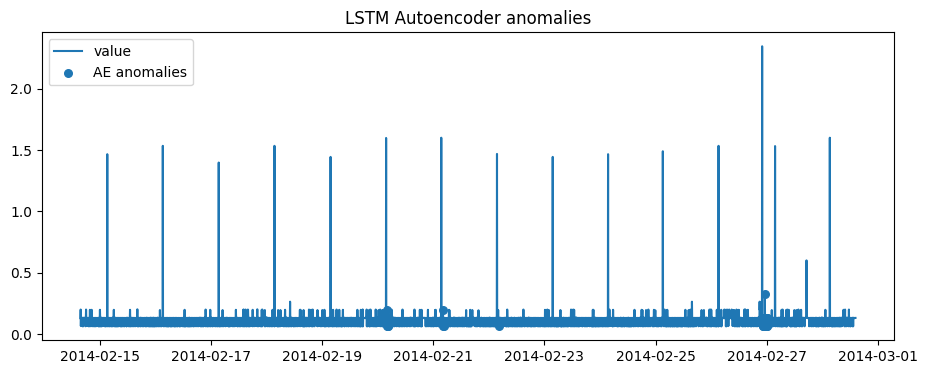

In [37]:
# Visualize
fig, ax = plt.subplots()
ax.plot(df_fe.index, df_fe["value"], label="value")
ax.scatter(df_fe.index[df_fe["anomaly_ae"]==1], df_fe.loc[df_fe["anomaly_ae"]==1,"value"],
           marker="o", s=30, label="AE anomalies")
ax.legend(); ax.set_title("LSTM Autoencoder anomalies")
plt.show()

In [38]:
# Proxy: anomalies should coincide with large |zscore| or large |resid|
proxy = (df_fe["zscore"].abs() > 2.5) | (df_fe["resid"].abs() > df_fe["resid"].std()*2.5)
y_proxy = proxy.astype(int)

In [39]:
def report(name, y_pred):
    p,r,f,_ = precision_recall_fscore_support(y_proxy, y_pred, average="binary", zero_division=0)
    print(f"{name}  precision={p:.3f} recall={r:.3f} f1={f:.3f}")


In [40]:
report("IsolationForest", df_fe["anomaly_iso"])
report("Autoencoder", df_fe["anomaly_ae"])

IsolationForest  precision=0.375 recall=0.405 f1=0.390
Autoencoder  precision=0.026 recall=0.027 f1=0.026


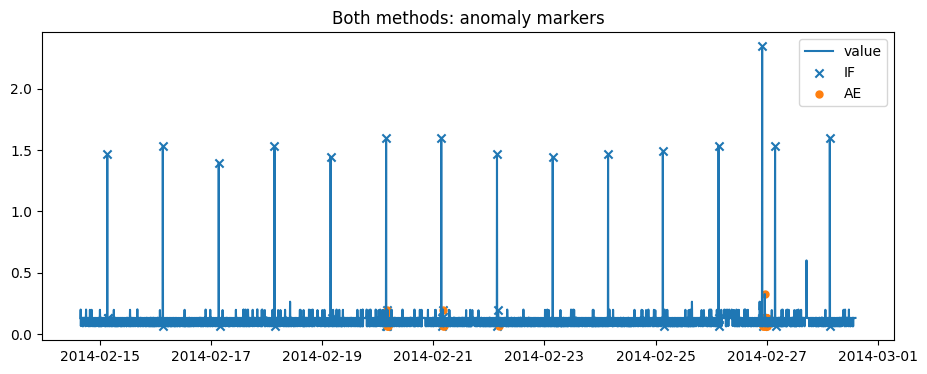

In [41]:
fig, ax = plt.subplots()
ax.plot(df_fe.index, df_fe["value"], label="value")
ax.scatter(df_fe.index[df_fe["anomaly_iso"]==1], df_fe.loc[df_fe["anomaly_iso"]==1,"value"],
           marker="x", s=35, label="IF")
ax.scatter(df_fe.index[df_fe["anomaly_ae"]==1], df_fe.loc[df_fe["anomaly_ae"]==1,"value"],
           marker="o", s=25, label="AE")
ax.legend(); ax.set_title("Both methods: anomaly markers")
plt.show()